In [1]:
import pandas as pd
import random as rd
from collections import Counter
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_random_solution(df):
    category = df.category.values.tolist()
    np.random.shuffle(category)
    category_copy = category.copy()
    hard_constrait = []
    for cand in category_copy:
        if cand == 'Ht' or cand == 'St':
            hard_constrait.append(cand)
            category.remove(cand)

    empty_space = total - len(hard_constrait)

    soft_constrait = []
    for cand in range(empty_space):
        soft_constrait.append(np.random.choice(category))

    solution = hard_constrait + soft_constrait
    
    return solution, hard_constrait, category

In [3]:
def evaluate_solution(solution, weight):
    frequency = Counter(solution)
    loss = 0
    for category in solution: loss += weight[category] * frequency[category]
    return loss

In [4]:
def mutate_solution(hard_constrait, category):
#   mutate the solution by generating new soft constrait solution
    empty_space = total - len(hard_constrait)

    soft_constrait = []
    for cand in range(empty_space):
        soft_constrait.append(np.random.choice(np.array(category)))

    solution = hard_constrait + soft_constrait
    
    return solution

In [24]:
def hill_climbing_CA(df, num_itr = 200):
    start_time = time.time()
    record = {}
    solution, hard_sol, soft_cat = generate_random_solution(df)
    cost = evaluate_solution(solution, weight)
    
    best_solution = solution
    cost_best_solution = cost
    record[0] = cost_best_solution
    print("Iteration 0 ------ cost:- {}".format(cost))
    
    for itr in range(1, num_itr+1):
        solution = mutate_solution(hard_sol, soft_cat)
        cost = evaluate_solution(solution, weight)
        
        if cost > cost_best_solution:
            print("Iteration {} ------ Found a better solution with cost:- {}".format(itr, cost))
            best_solution = solution
            cost_best_solution = cost
            record[itr] = cost_best_solution
            
    end_time = time.time()
    
    print("\n Time taken - {}seconds".format(end_time-start_time))
    return best_solution, record

In [6]:
def generate_random_solution_HA(CA, HA_stat):
    generated = {}
    CA_copy = CA.copy()
    for hall in HA_stat:
        candidates = []
        for count in range(HA_stat[hall]):
            student = np.random.choice(CA_copy)
            candidates.append(student)
            CA_copy.remove(student)
        generated[hall] = candidates
    
    generated = list(generated.values())
    
    matrix_solution = []
    for hall in generated:
        solution = []
        
        frequency = Counter(hall) #count each category in each hall
        for category in order:
            solution.append(frequency[category]) #append count of each category in each hall
        
        matrix_solution.append(solution) # concatenate solutions of all categories in all halls together
    
#     transpose solution to allow rows represent each category and column represent each hall
    matrix_solution = np.array(matrix_solution).transpose()
    return matrix_solution

In [7]:
def evaluate_solution_FA(solution, data):
    solution = {i:j for i,j in zip(data, solution)}
    cost = 0
    for cat in solution: #loop through each category 
        proportion = data[cat] - (max(solution[cat]) - min(solution[cat]))
        N = sum(solution[cat] > 0 ) #number of halls that have some students of i-th category
        cost += proportion * N
    return cost

In [25]:
def hill_climbing_HA(num_itr = 200):
    start_time = time.time()
    record = {}
    solution = generate_random_solution_HA(best_solution_CA, HA_data)
    cost = evaluate_solution_FA(solution, best_solution_CA_dict)
    record[0] = cost
    best_solution = solution
    cost_best_solution = cost
    print("Iteration 0 ------ cost:- {}".format(cost))
    
    for itr in range(1, num_itr+ 1):
        solution = generate_random_solution_HA(best_solution_CA, HA_data)
        cost = evaluate_solution_FA(solution, best_solution_CA_dict)
        
        if cost > cost_best_solution:
            print("Iteration {} ------ Found a better solution with cost:- {}".format(itr, cost))
            best_solution = solution
            cost_best_solution = cost
            record[itr] = cost
            
    end_time = time.time()
    
    print("\n Time taken - {}seconds".format(end_time-start_time))
    print(' Best Fitness value -', cost_best_solution)
    return best_solution, record

## **Implementation - Male applicants**

In [9]:
male_df = pd.read_csv('male_applicants.csv')
male_df.head()

,names,category,weight
0,rqtttt,Ot,0.5
1,zhuztd,Ot,0.5
2,hqxfqg,Ot,0.5
3,sanjtt,Fy,0.5
4,mjbgpk,Ot,0.5


In [10]:
#this represents the amount of student that applied for each category
male_data = {'Fy': 1360, 'Fr':1660, 'Ht':60, 'Sp':290, 'St':260, 'Ot':3736} 

#total amount of students that can be taken by all male hostels
total = 2072 

#total amount of students that belong to the soft constrait group
soft_constr_weight = 1368 + 1660 + 290 + 3736 

#weight the population of the soft constrait group based the amount of people that applied
weight = {'Fy': 1 - (1360/soft_constr_weight), 'Fr': 1-(1660/soft_constr_weight), 'Ht':1, 'Sp':1- (290/soft_constr_weight), 'St':1, 'Ot': 1- (3736/soft_constr_weight)}
print(weight)

{'Fy': 0.8072015877516303, 'Fr': 0.7646725262262546, 'Ht': 1, 'Sp': 0.9588885738588036, 'St': 1, 'Ot': 0.47037142047065494}


In [11]:
HA_data = {'Akindeko': 625, 'Abiola':356, 'Adeniyi':195, 'New Male Hostel':792, 'Bisi Balogun':104}
order = ['Fy','Fr','Ht','Sp','St','Ot']

#### **Generate a random solution - Category Allocation (CA): MALE APPLICANTS**

In [12]:
solution, _ , _= generate_random_solution(male_df)
frequency = Counter(solution)

show = pd.DataFrame()
for i in frequency: show[i] = [frequency[i]]
show.head()

,St,Ht,Ot,Fr,Fy,Sp
0,260,60,944,387,352,69


#### **Hill Climbing optimized solution - Category Allocation (CA) MALE APPLICANTS**

In [13]:
best_solution_CA, graph = hill_climbing_CA(male_df)

frequency = Counter(best_solution_CA)

best_solution_CA_dict = {i:j for i,j in frequency.items()}

show = pd.DataFrame()
for i in frequency: show[i] = [frequency[i]]
show.head()

Iteration 0 ------ cost:- 708671.6385029744
Iteration 1 ------ Found a better solution with cost:- 712474.2015877555
Iteration 15 ------ Found a better solution with cost:- 715740.9296852736
Iteration 31 ------ Found a better solution with cost:- 722653.3079104152
Iteration 78 ------ Found a better solution with cost:- 723085.4074284217
Iteration 162 ------ Found a better solution with cost:- 724024.2347604345

 Time taken - 203.98590064048767seconds


,St,Ht,Fr,Fy,Ot,Sp
0,260,60,436,308,954,54


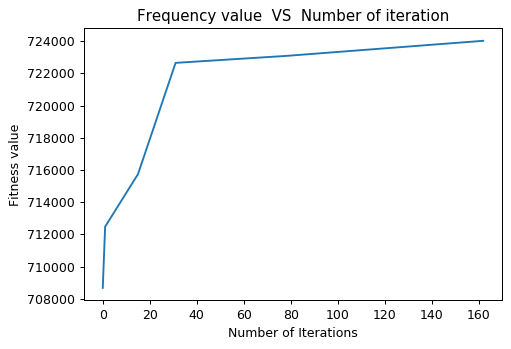

In [14]:
plt.figure(dpi = 90)
plt.title("Frequency value  VS  Number of iteration")
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness value')
plt.plot(list(graph.keys()), list(graph.values()))
plt.show()

#### **Generate a random solution- Hall Allocation (HA) MALE APPLICANTS**

In [18]:
solution_HA = generate_random_solution_HA(best_solution_CA, HA_data)

show = pd.DataFrame(solution_HA,
                    columns = ['Akindeko', 'Abiola', 'Adeniyi', 'New Male Hostel', 'Bisi Balogun'],
                    index = ['Fy','Fr','Ht','Sp','St','Ot'])

show

,Akindeko,Abiola,Adeniyi,New Male Hostel,Bisi Balogun
Fy,92,51,32,125,8
Fr,144,65,45,159,23
Ht,14,15,4,23,4
Sp,18,11,3,20,2
St,77,44,24,100,15
Ot,280,170,87,365,52


#### **HIll Climbing optimized solution- Hall Allocation (HA) MALE APPLICANTS**

In [28]:
result, graph = hill_climbing_HA(200) 
show = pd.DataFrame(result,
                    columns = ['Akindeko', 'Abiola', 'Adeniyi', 'New Male Hostel', 'Bisi Balogun'],
                    index = ['Fy','Fr','Ht','Sp','St','Ot'])

show

Iteration 0 ------ cost:- 6900
Iteration 1 ------ Found a better solution with cost:- 6920

 Time taken - 108.90916872024536seconds
 Best Fitness value - 6920


,Akindeko,Abiola,Adeniyi,New Male Hostel,Bisi Balogun
Fy,83,49,37,121,18
Fr,137,69,37,171,22
Ht,15,13,5,23,4
Sp,16,10,3,23,2
St,76,42,25,110,7
Ot,298,173,88,344,51


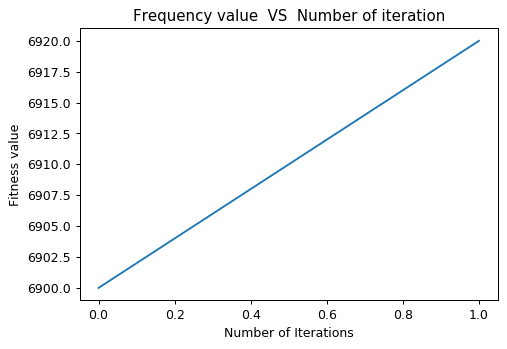

In [30]:
plt.figure(dpi = 90)
plt.title("Frequency value  VS  Number of iteration")
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness value')
plt.plot(list(graph.keys()), list(graph.values()))
plt.show()

## **Implementation - Female applicants**

In [31]:
# Read in data
female_df = pd.read_csv('female_applicants.csv')
female_df.head()

,names,category
0,ymguns,Fy
1,xhvcdk,Fy
2,vdnszo,Ot
3,vbcnxs,Ot
4,wcdduo,Ot


In [32]:
#this represents the amount of student that applied for each category
female_data = {'Fy': 820, 'Fr':958, 'Ht':56, 'Sp':80, 'St':100, 'Ot':1120} 

#total amount of students that can be taken by all male hostels
total = 1593

#total amount of students that belong to the soft constrait group
soft_constr_weight = 820 + 958 + 80 + 1120 

#weight the population of the soft constrait group based the amount of people that applied
weight = {'Fy': 1 - (820/soft_constr_weight), 'Fr': 1-(958/soft_constr_weight), 'Ht':1, 'Sp':1- (80/soft_constr_weight), 'St':1, 'Ot': 1- (1120/soft_constr_weight)}
print(weight)

{'Fy': 0.7246474143720618, 'Fr': 0.6783075889858965, 'Ht': 1, 'Sp': 0.9731363331094695, 'St': 1, 'Ot': 0.6239086635325721}


In [33]:
#amount of students that can be allocated to each male hostel
HA_data = {'New Female Hostel': 792, 'Jadesola':229, 'Jibowu(Main)':332, 'Jibowu Annex 1':80, 'Jibowu Annex 2':80,'Jibowu Annex 3':80}
order = ['Fy','Fr','Ht','Sp','St','Ot']

#### **Generate a random solution - Category Allocation (CA): FEMALE APPLICANTS**

In [34]:
solution, _ , _= generate_random_solution(female_df)
frequency = Counter(solution)

show = pd.DataFrame()
for i in frequency: show[i] = [frequency[i]]
show.head()

,St,Ht,Fr,Ot,Fy,Sp
0,100,56,453,542,402,40


#### **Hill Climbing optimized solution - Category Allocation (CA) FEMALE APPLICANTS**

In [37]:
best_solution_CA, graph = hill_climbing_CA(female_df)

frequency = Counter(best_solution_CA)

best_solution_CA_dict = {i:j for i,j in frequency.items()}

show = pd.DataFrame()
for i in frequency: show[i] = [frequency[i]]
show.head()

Iteration 0 ------ cost:- 460952.5963734047
Iteration 3 ------ Found a better solution with cost:- 462459.16252518515
Iteration 11 ------ Found a better solution with cost:- 465897.27199462964
Iteration 159 ------ Found a better solution with cost:- 466546.8972464737
Iteration 177 ------ Found a better solution with cost:- 466901.8515782469

 Time taken - 76.42845320701599seconds


,St,Ht,Fy,Fr,Ot,Sp
0,100,56,396,462,559,20


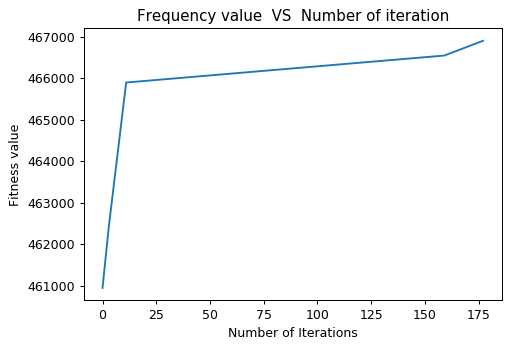

In [38]:
plt.figure(dpi = 90)
plt.title("Frequency value  VS  Number of iteration")
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness value')
plt.plot(list(graph.keys()), list(graph.values()))
plt.show()

#### **Hill Climbing optimized solution- Hall Allocation (HA) FEMALE APPLICANTS**

In [40]:
result, graph = hill_climbing_HA(200) 
show = pd.DataFrame(result,
                    columns = ['New Female Hostel', 'Jadesola', 'Jibowu(Main)', 'Jibowu Annex 1', 'Jibowu Annex 2','Jibowu Annex 3'],
                    index = ['Fy','Fr','Ht','Sp','St','Ot'])

show

Iteration 0 ------ cost:- 4818
Iteration 2 ------ Found a better solution with cost:- 5220
Iteration 18 ------ Found a better solution with cost:- 5250

 Time taken - 62.4948308467865seconds
 Best Fitness value - 5250


,New Female Hostel,Jadesola,Jibowu(Main),Jibowu Annex 1,Jibowu Annex 2,Jibowu Annex 3
Fy,189,54,90,20,21,22
Fr,239,68,90,24,20,21
Ht,28,10,10,2,5,1
Sp,7,6,4,1,1,1
St,47,11,25,5,6,6
Ot,282,80,113,28,27,29


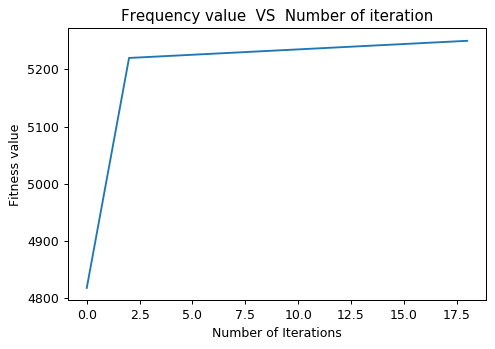

In [41]:
plt.figure(dpi = 90)
plt.title("Frequency value  VS  Number of iteration")
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness value')
plt.plot(list(graph.keys()), list(graph.values()))
plt.show()